In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam

Using TensorFlow backend.


In [10]:
print(tf.__version__)

2.1.0


In [7]:
image_width = 256
image_height = 256
batch_size = 16
data_directory = "./data"
train_directory = data_directory + "/train"
test_directory = data_directory + "/test"

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_directory,
                                               color_mode="rgb",
                                               shuffle=True,
                                               target_size=(image_width, image_height),
                                               class_mode='sparse')


image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=test_directory,
                                                 color_mode="rgb",
                                                 target_size=(image_width, image_height),
                                                 class_mode='sparse')

Found 5214 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


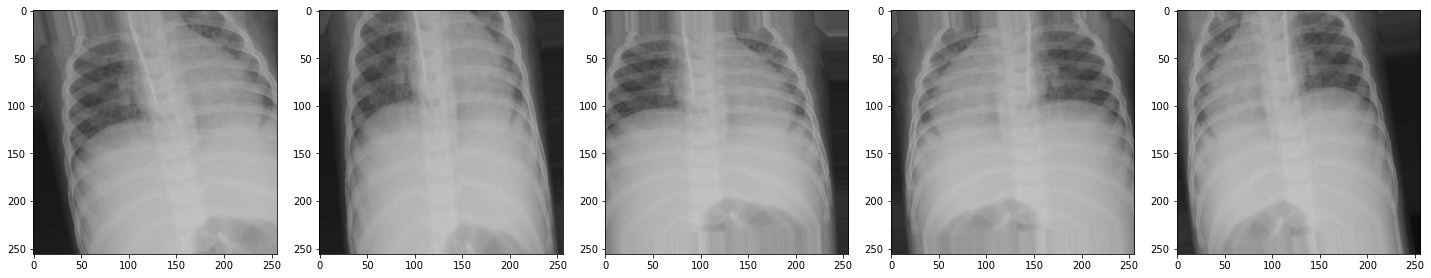

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [10]:
num_nor_tr = len(os.listdir(train_directory + '/NORMAL'))
num_bac_tr = len(os.listdir(train_directory + '/BACTERIA'))
num_vir_tr = len(os.listdir(train_directory + '/VIRUS'))

num_nor_val = len(os.listdir(test_directory + '/NORMAL'))
num_bac_val = len(os.listdir(test_directory + '/BACTERIA'))
num_vir_val = len(os.listdir(test_directory + '/VIRUS'))

total_train = num_nor_tr + num_bac_tr + num_vir_tr
total_val = num_nor_val + num_bac_val + num_vir_val

total_train, total_val

(5215, 626)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=train_data_gen.image_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation='softmax')
])
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=10
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size))),
    )

NameError: name 'Adam' is not defined

In [18]:
model.save_weights('model.h5')


model_json = model.to_json()
with open('modelj.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the disk.')

Model saved to the disk.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

In [13]:
MODEL_ARCHITECTURE = 'model.json'
MODEL_WEIGHTS = 'model.h5'
json_file = open(MODEL_ARCHITECTURE)
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(MODEL_WEIGHTS)
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [14]:
testdatagenerat = ImageDataGenerator(rescale=1. / 255)
testgenerat = testdatagenerat.flow_from_directory(
        test_directory,
        target_size=(256, 256),
        shuffle=False,
        class_mode='sparse',
        batch_size=1)

Found 624 images belonging to 3 classes.


In [19]:
model.evaluate(testgenerat, steps=None, 
                         callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

  ...
    to  
  ['...']


[0.5656636289172522, 0.7724359]

In [20]:
test_filenames = testgenerat.filenames
test_steps = len(test_filenames)

predictions = model.predict(testgenerat, steps = test_steps)

print(predictions)

[[8.9726514e-01 1.4543188e-02 8.8191599e-02]
 [9.1324031e-01 2.3580739e-02 6.3178927e-02]
 [9.7086638e-01 5.9357373e-04 2.8540002e-02]
 ...
 [3.2138193e-01 6.7592151e-02 6.1102599e-01]
 [8.2466000e-01 1.0824743e-01 6.7092538e-02]
 [8.4379303e-01 9.0214759e-02 6.5992281e-02]]


In [17]:
y_hat = np.argmax(predictions, axis = 1) 
y_true = testgenerat.classes

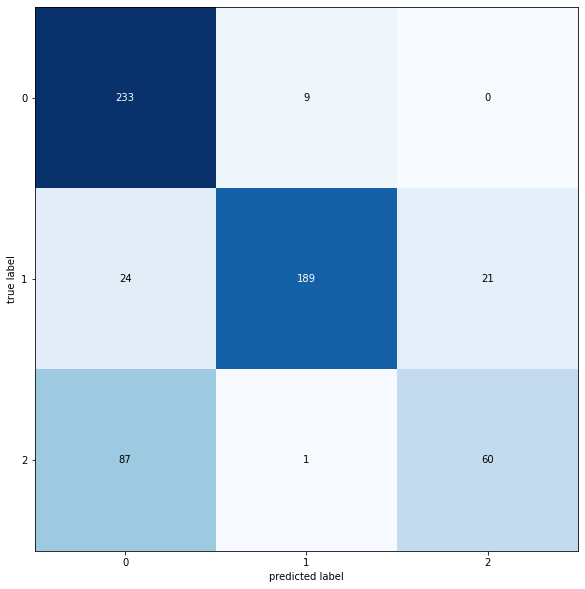

In [18]:
CM = confusion_matrix(y_true, y_hat)
fig, ax = plot_confusion_matrix(conf_mat=CM,  figsize=(10, 10))
plt.show()

In [ ]:
score = model.evaluate(testgenerat)

print("Loss",score[0])
print("Accuracy",score[1])